# Locating Halos/subhalo Galaxies CAMELS

In [ ]:
#!pip install treecorr

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import h5py
%matplotlib inline
import treecorr
import time

Getting galaxy data

In [2]:
# catalogue name
catalogue = r'C:\CAMELS DATA\LH290_fof_subhalo_tab_033.hdf5'

# value of the scale factor
scale_factor = 1.0

# open the catalogue
f = h5py.File(catalogue, 'r')
# read the positions, velocities and masses of the FoF halos
pos_h  = f['Group/GroupPos'][:]/1e3           #positions in Mpc/h
#vel_h  = f['GroupVel'][:]/scale_factor  #velocities in km/s
mass_h = f['Group/GroupMass'][:]*1e10         #masses in Msun/h

# read the positions, black hole masses and stellar masses of the subhalos/galaxies
mass_g = f['Subhalo/SubhaloMass'][:]*1e10    # galaxy mass in Msin/h
pos_sh  = f['Subhalo/SubhaloPos'][:]/1e3        #positions in Mpc/h

subh_M_R_12 = f['Subhalo/SubhaloMassInRadType'][:,4]*1e10 # total stellar mass of twice the stellare alf-mass radius in Msun/h

# close file
f.close()
pos_g = pos_sh[subh_M_R_12>1e8]
n_galaxies = pos_g.shape[0]
print('Number of galaxies: ',pos_g.shape)
print('Number of Halos: ',pos_h.shape)

Number of galaxies:  (1060, 3)
Number of Halos:  (17499, 3)


Slicing Subhalos

In [3]:
box_length = 25.0  # Length of the 3D box
num_slices = 15  # Number of slices

slice_size = box_length / num_slices  # Size of each slice along the z-axis

# Initialize an empty dictionary to store the particle positions for each slice
sliced_positions = {}
sliced_masses = {}
# Initialize the dictionary with empty arrays for each slice
for i in range(16):
    sliced_positions[i] = []
    sliced_masses[i] = []
# Iterate over each particle position
for position in pos_g:
    # Calculate the index of the slice based on the z-coordinate
    slice_index = int(position[2] // slice_size)

    # Append the position to the corresponding slice's array
    sliced_positions[slice_index].append(position)
    pos_index = np.where(pos_g==position)[0][0]
    sliced_masses[slice_index].append(mass_g[pos_index])

# Convert the lists to numpy arrays
for slice_index in sliced_positions:
    sliced_positions[slice_index] = np.array(sliced_positions[slice_index])
    sliced_masses[slice_index] = np.array(sliced_masses[slice_index])
# Print the positions for each slice
for slice_index in sliced_positions:
    print(f"Slice {slice_index} shape: ", sliced_positions[slice_index].shape)

Slice 0 shape:  (49, 3)
Slice 1 shape:  (79, 3)
Slice 2 shape:  (57, 3)
Slice 3 shape:  (75, 3)
Slice 4 shape:  (75, 3)
Slice 5 shape:  (77, 3)
Slice 6 shape:  (50, 3)
Slice 7 shape:  (63, 3)
Slice 8 shape:  (100, 3)
Slice 9 shape:  (69, 3)
Slice 10 shape:  (67, 3)
Slice 11 shape:  (101, 3)
Slice 12 shape:  (83, 3)
Slice 13 shape:  (48, 3)
Slice 14 shape:  (67, 3)
Slice 15 shape:  (0,)


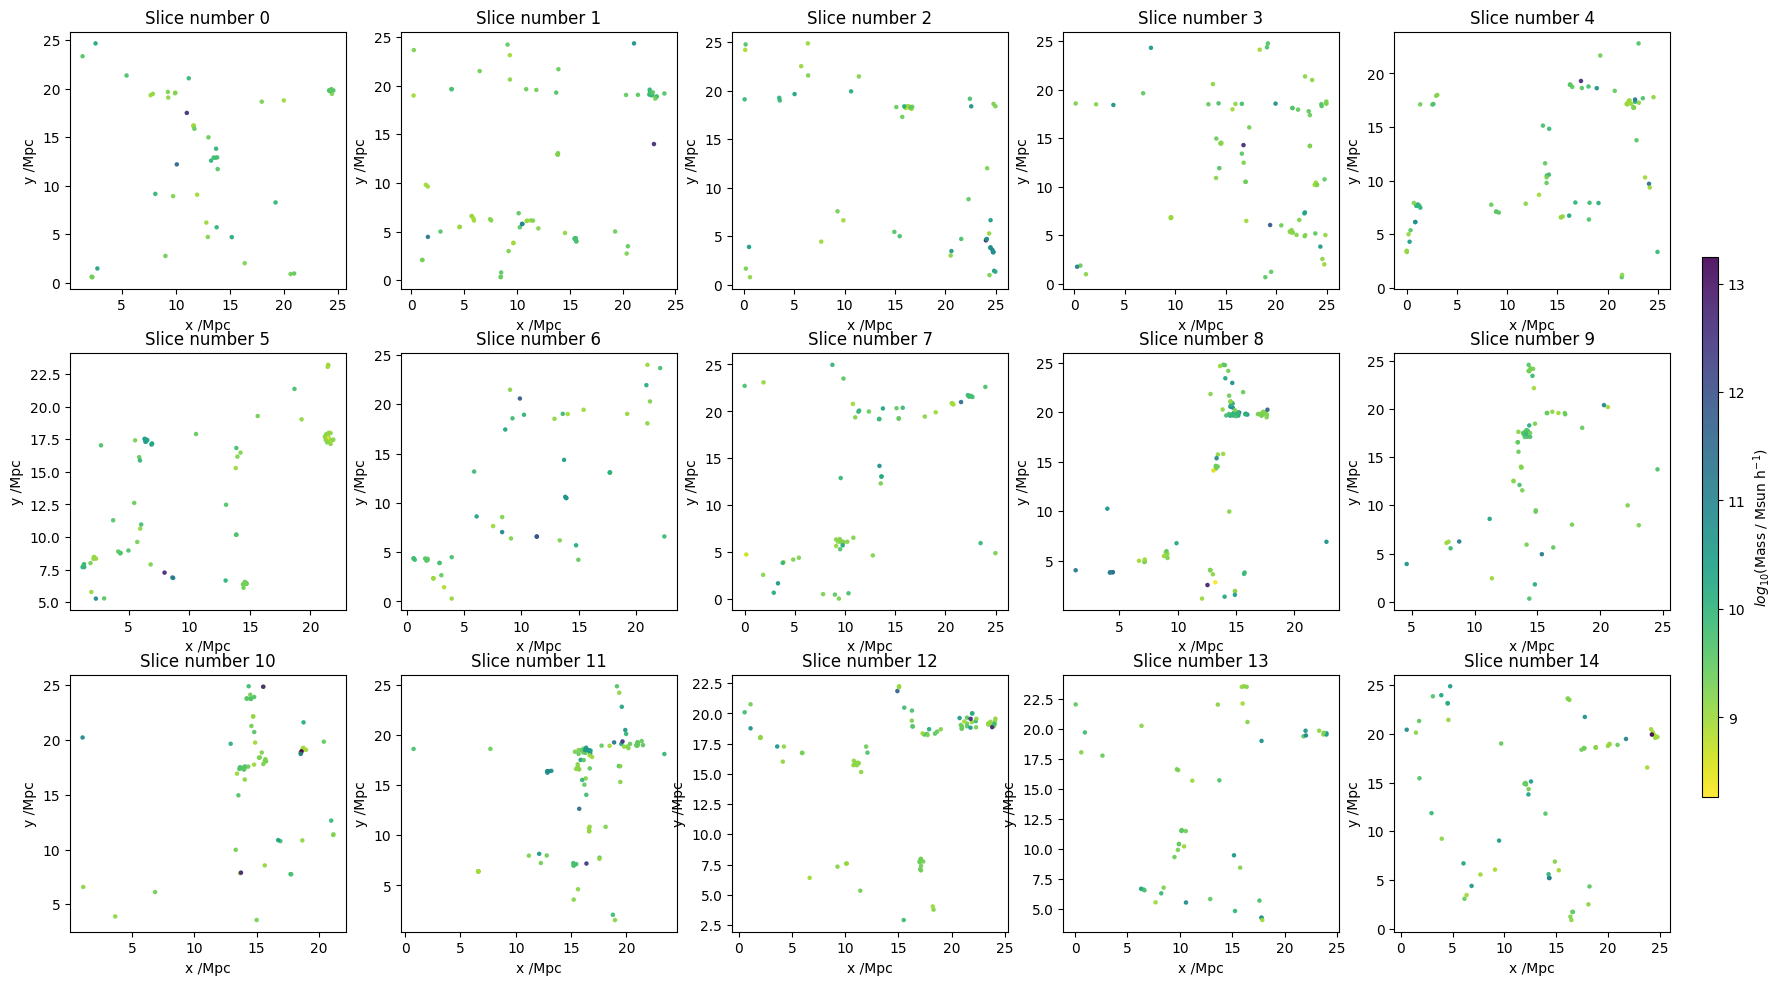

In [4]:
from matplotlib import cm
fig = plt.figure(figsize=(16,9))
cbar_ax = fig.add_axes([1.02, 0.15, 0.01, 0.6])  # Define position of the colorbar
colormap = cm.get_cmap('viridis')
reversed_colormap = colormap.reversed() # Reverse the colormap
for i in range(15):
    ax = fig.add_subplot(3,5,i+1)
    im= ax.scatter(sliced_positions[i][:,0] , sliced_positions[i][:,1], c=np.log10(sliced_masses[i]),
               vmin=min(np.log10(mass_g)), vmax=max(np.log10(mass_g)), marker='o', s=5, alpha=0.9,
                  cmap=reversed_colormap)
    ax.set_xlabel('x /Mpc')
    ax.set_ylabel('y /Mpc')
    ax.set_title(f'Slice number {i}')

cbar = fig.colorbar(im, cax=cbar_ax)  # Use the predefined colorbar axes
cbar.set_label(r'$log_{10}$(Mass / Msun h$^{-1}$)')
fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, 
                        wspace=0.2, 
                        hspace=0.25)

### FInding the correlation for each slice
First we have to make a random calalogue.

In [5]:
def dot_gen(N,xlim,ylim,zlim):
    '''Generates N dots at uniformly random positions.
     Outputs: (Nx3) array 2st index x, y, z corrdinate,
                            1rd index N dots'''

    # randomly distribute x, y values (centre of stick)
    x = np.random.uniform(low=0.0, high=xlim, size=N)
    y = np.random.uniform(low=0.0, high=ylim, size=N)
    z = np.random.uniform(low=0.0, high=zlim, size=N)

    dots = np.transpose(np.array([x,y,z]))

    return dots

In [6]:
rand_xyz = dot_gen(N=n_galaxies,xlim=25,ylim=25,zlim=25)
print(rand_xyz.shape)

(1060, 3)


<IPython.core.display.Javascript object>


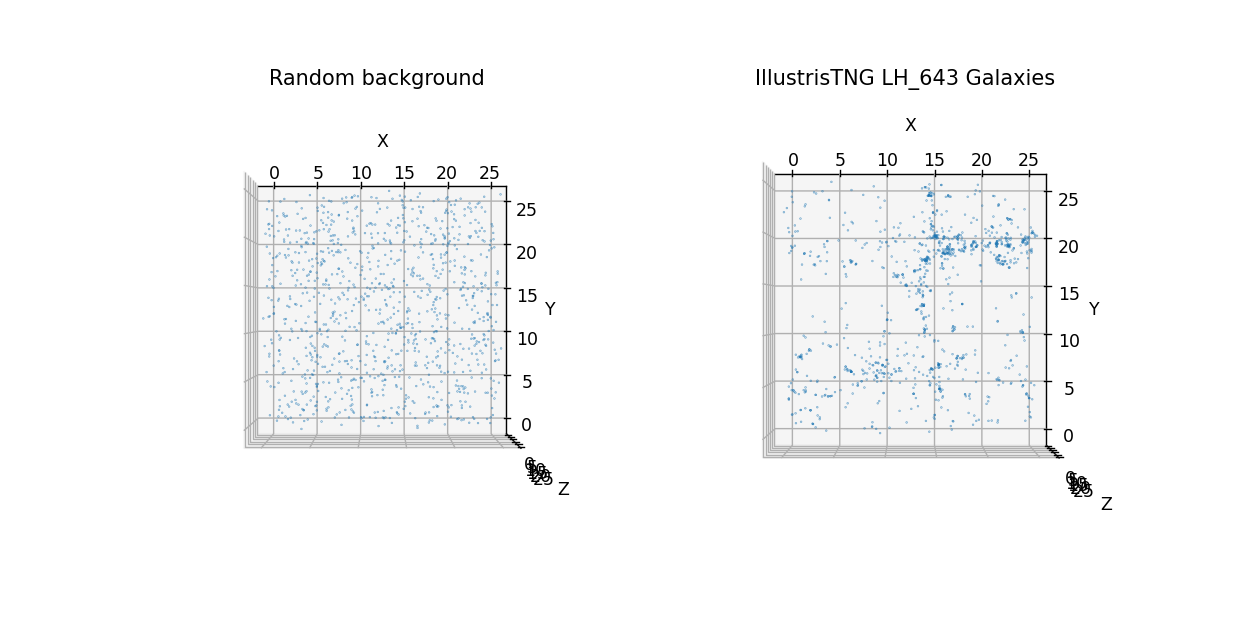

In [7]:
%matplotlib notebook
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1,projection='3d')
scatter = ax.scatter(rand_xyz[:,0] , rand_xyz[:,1], rand_xyz[:,2], marker='o', s=0.1,alpha=0.7)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Random background')
ax.view_init(elev=90, azim=270)
ax.set_box_aspect([1,1,1])

ax2 = fig.add_subplot(1,2,2,projection='3d')
scatter2 = ax2.scatter(pos_g[:,0] , pos_g[:,1], pos_g[:,2], marker='o', s=0.1,alpha=0.7)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('IllustrisTNG LH_643 Galaxies')
ax2.view_init(elev=90, azim=270)

In [8]:
# rand initialise
rand = treecorr.Catalog(x=rand_xyz[:,0], y=rand_xyz[:,1], z=rand_xyz[:,2], npatch =20)
rr = treecorr.NNCorrelation(min_sep=0.1, max_sep=43,  nbins=150, var_method='jackknife')
# data initialise
corr = treecorr.Catalog(x=sliced_positions[0][:,0], y=sliced_positions[0][:,1],
                        z=sliced_positions[0][:,2], npatch =20) # two shear values (g1, g2) -> (ellipticity and angle)
nn = treecorr.NNCorrelation(min_sep=0.1, max_sep=43, nbins=150, var_method='jackknife')#, sep_units='arcmin')
print('bin_size = %.6f'%nn.bin_size)
t1 = time.time()
nn.process(corr)  # Takes approx 1 minute / million objects
t2 = time.time()
rr.process(rand)
t3 = time.time()
print('Time for calculating nn correlation = ',t2-t1)
print('Time for calculating rr correlation = ',t3-t2)

xi, varxi = nn.calculateXi(rr=rr) # Finding correlation function
r = nn.rnom
sigma = np.sqrt(varxi)
tot_pairs = nn.tot
npairs = nn.npairs

bin_size = 0.040425
Time for calculating nn correlation =  0.04430031776428223
Time for calculating rr correlation =  0.05400419235229492


1200.5


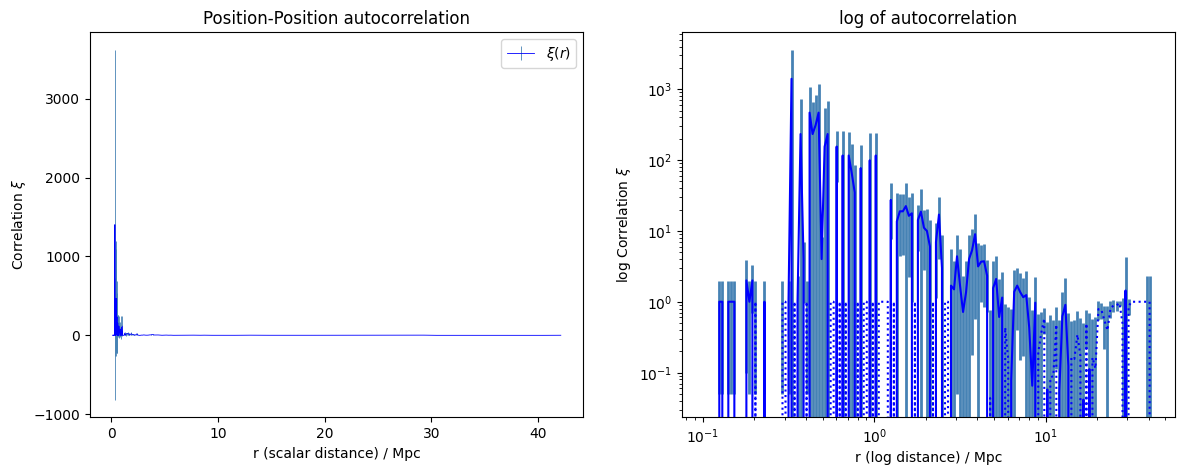

In [9]:
print(tot_pairs)
%matplotlib inline
fig = plt.figure(figsize=(14,5))

ax1 = fig.add_subplot(1,2,1)
ax1.errorbar(r, xi, yerr=sigma, color='blue', ecolor='steelblue', lw=0.6, ls='solid', label =r'$\xi(r)$')
ax1.set_xlabel(r'r (scalar distance) / Mpc')
ax1.set_ylabel(r'Correlation $\xi$')
ax1.set_title('Position-Position autocorrelation')
ax1.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.plot(r, xi, color='blue')
ax2.plot(r, -xi, color='blue', ls=':')
ax2.errorbar(r[xi>0], xi[xi>0], yerr=sigma[xi>0], color='blue',ecolor='steelblue', lw=2, ls='')
ax2.errorbar(r[xi<0], -xi[xi<0], yerr=sigma[xi<0], color='blue',ecolor='steelblue', lw=2, ls='')
#ax2.bar(r, npairs, color='pink', label='num pairs in each bin')
ax2.set_xlabel(r'r (log distance) / Mpc')
ax2.set_ylabel(r'log Correlation $\xi$')
ax2.set_title('log of autocorrelation')
ax2.set_xscale('log')
ax2.set_yscale('log', nonpositive='clip')

plt.show()

### A better estimator for the correlation function: the Landy-Szalay formula (nn-2nr+rr)/rr.

In [10]:
nr = treecorr.NNCorrelation(min_sep=0.1, max_sep=43, nbins=150, var_method='jackknife')
nr.process(corr, rand)
xi, varxi = nn.calculateXi(rr=rr, dr=nr)
sigma = np.sqrt(varxi)

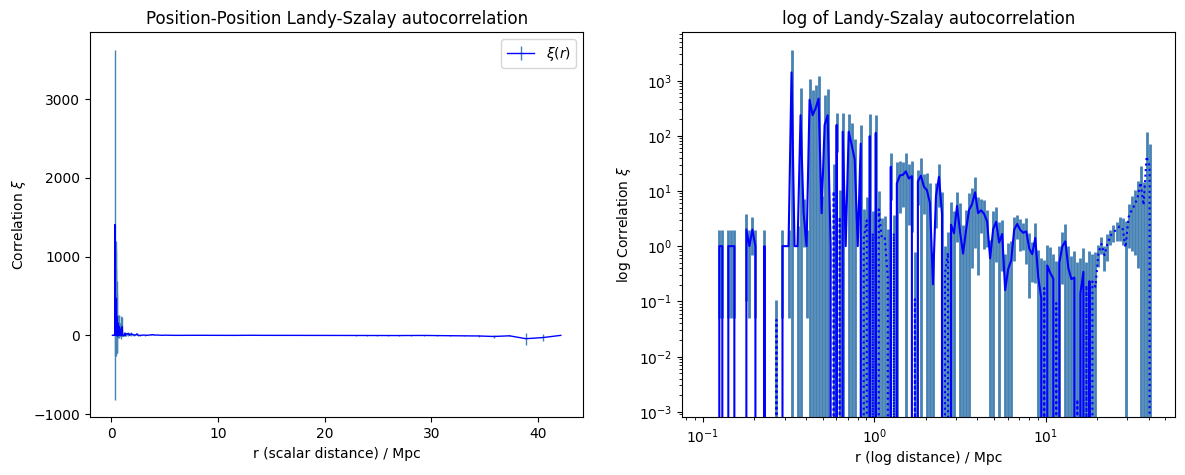

In [11]:
fig = plt.figure(figsize=(14,5))

ax1 = fig.add_subplot(1,2,1)
ax1.errorbar(r, xi, yerr=sigma, color='blue', ecolor='steelblue', lw=1, ls='solid', label =r'$\xi(r)$')
ax1.set_xlabel(r'r (scalar distance) / Mpc')
ax1.set_ylabel(r'Correlation $\xi$')
ax1.set_title('Position-Position Landy-Szalay autocorrelation')
ax1.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.plot(r, xi, color='blue')
ax2.plot(r, -xi, color='blue', ls=':')
ax2.errorbar(r[xi>0], xi[xi>0], yerr=sigma[xi>0], color='blue',ecolor='steelblue', lw=2, ls='')
ax2.errorbar(r[xi<0], -xi[xi<0], yerr=sigma[xi<0], color='blue',ecolor='steelblue', lw=2, ls='')
ax2.set_xlabel(r'r (log distance) / Mpc')
ax2.set_ylabel(r'log Correlation $\xi$')
ax2.set_title('log of Landy-Szalay autocorrelation')
ax2.set_xscale('log')
ax2.set_yscale('log', nonpositive='clip')

plt.show()